#Integrase_Enumerator Introduction

Integrase_Enumerator is a way to modularly define DNA constructs that can be recombined into other forms using integrases. Integrases in general are proteins that bind to a specific sequence and then cause a recombination event between two such sequences. In the case of `Serine Integrases`, these sequences are called `attP` and `attB`. So one very simple way to express an integrase reaction (where Bxb1 is an integrase) would be like this:

$attB + 2 Bxb1 \rightleftharpoons attB:Bxb1$

$attP + 2 Bxb1 \rightleftharpoons attP:Bxb1$

$attB:Bxb1 + attP:Bxb1 \xrightarrow{k_{int}} attL:Bxb1 + attR:Bxb1$

(Bxb1 unbinding from attL and attR is not shown)

With this simple schematic, very complex dna manipulations can be performed.



In [1]:
from biocrnpyler import *

try:
    #dnaplotlib is a cool library for plotting DNAs.
    #please use my fork located at https://github.com/dr3y/dnaplotlib
    #to install it type: pip install git+git://github.com/dr3y/dnaplotlib.git@master
    import dnaplotlib as dpl
    %matplotlib inline
    dpl_enabled = True
except (ModuleNotFoundError,ImportError) as e:
    dpl_enabled = False
print("imports done!")

def plotNetwork(inCRN,use_pretty_print=True,colordict = None,iterations=2000,rseed=30,posscale=1,export=False):
    try:
        from bokeh.models import (Plot , Range1d)

        import bokeh.plotting
        import bokeh.io
        bokeh.io.output_notebook() #this makes the graph appear in line with the notebook
        if(colordict is None):
            colordict={"complex":"cyan","protein":"green",
                        "GFP":"lightgreen",
                        "RFP":"red",
                        "ribosome":"blue",
                        "dna":"white","rna":"orange",
                        "ligand":"pink","phosphate":"yellow","nothing":"purple"}
        layout_str = "force"
        DG, DGspec, DGrxn = generate_networkx_graph(inCRN,use_pretty_print=use_pretty_print,colordict=colordict) #this creates the networkx objects
        plot = Plot(plot_width=500, plot_height=500, x_range=Range1d(-500, 500), y_range=Range1d(-500, 500)) #this generates a 
        if(export):
            plot.output_backend = "svg"
        graphPlot(DG,DGspec,DGrxn,plot,layout=layout_str,posscale=posscale,iterations=iterations,rseed=rseed) #now you draw the network on the plot. Layout "force" is 
        bokeh.io.show(plot) #if you don't type this the plot won't show
        if(export):
            bokeh.io.export_svgs(plot, "plot_file.svg")
            
    except ModuleNotFoundError:
        return None

imports done!


0


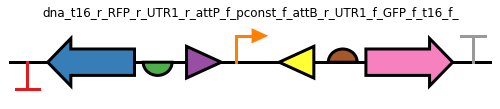

0


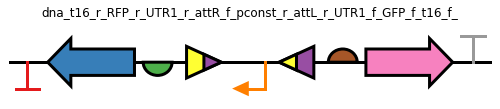

In [2]:
#first, we define basic construct components

ptet = RegulatedPromoter("ptet",["tetr"],leak=True) #this is a repressible promoter
pconst = Promoter("pconst") #constitutive promoter
utr1 = RBS("UTR1") #regular RBS
gfp = CDS("GFP")
rfp = CDS("RFP")
t16 = Terminator("t16") #a terminator stops transcription
#some parameters are useful also. note the "kint" parameter which determines the rate of recombination
parameters={"cooperativity":2,"kb":100, "ku":10, "ktx":.05, "ktl":.2, "kdeg":2,"kint":.05}
#here is where we define the integrase attachment sites

attP = AttachmentSite("attP","attP",integrase="Bxb1") #the first argument is the name of this attachment site, the second argument is the type of attachment site it is ("attP", "attB", "attL" or "attR") and the integrase denotes which integrase binds to this site (default is "int1")

attB = AttachmentSite("attB","attB",integrase="Bxb1") #we define two attachment sites, as one site doesn't do anything on its own besides bind integrases

bxb1_mechanism = IntegraseMechanism("Bxb1", reactions={("attB","attP"):"attL",("attP","attB"):"attR"})
#an integrase mechanism explains how the integrase functions. It is a dictionary which has valid combinations of sites for the keys, and the values are the names of the new sites generated. When two sites combine, they create two different sites, which are the result of the sites themselves getting recombined. In the real system, it's a bit like this:
#A==attB1:attB2==B + C==attP1:attP2==D -> A==attB1:attP2==D + C==attP1:attB2==B
#so then we say, attB1:attB2 is attB, attP1:attP2 is attP, attB1:attP2 is attL, attP1:attB2 is attR. the == represents a strand of DNA, labeled with A-D to keep them distinct
#If we are tracking what happens to the "A" strand, then we can simplify this a bit to say:
#A:attB + attP -> A:attL
#and likewise for the "C" strand,
#C:attP + attB -> C:attR
#this is what the "reactions" argument represents, and this is its default value.


bxb1 = Integrase_Enumerator("Bxb1", int_mechanisms={"Bxb1":bxb1_mechanism}) #we must also define an integrase enumerator. The default integrase is always "int1", but here we are specifying "Bxb1" as the integrase. The Integrase enumerator gets a name, and the mechanism we defined above.

#now that the parts are defined, we can put together our construct.
promoter_flip = DNA_construct([[t16,"reverse"],[rfp,"reverse"],[utr1,"reverse"],[attP,"forward"],[pconst,"forward"],[attB,"reverse"],[utr1,"forward"],[gfp,"forward"],[t16,"forward"]])

#this is organized in a "promoter flipping" arrangment where the integrase causes an intramolecular reaction that results in the promoter facing the other direction, and transcribing a different set of genes.

myMixture = TxTlExtract(name = "txtl", parameters = parameters, components = [promoter_flip],global_component_enumerators=[bxb1]) #to activate integrase reactions you must add our `Integrase_Enumerator` as a global_component_enumerator in the mixture.

enumerated_constructs = myMixture.global_component_enumeration(recursion_depth=4)
#then, we can plot the DNA constructs that will be present in our CRN:
if(dpl_enabled):
    for construct in enumerated_constructs:
        if(isinstance(construct,DNA_construct)):
            plotConstruct(construct,plot_rnas=False)

#and, simulate the CRN
myCRN = myMixture.compile_crn()


Loading BokehJS ...

D:\anaconda3\lib\site-packages\bokeh\plotting\graph.py:120: UserWarning: Node keys in 'layout_function' don't match node keys in the graph. These nodes may not be displayed correctly.
  warn("Node keys in 'layout_function' don't match node keys in the graph. "


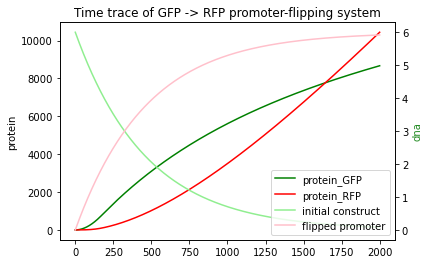

In [38]:
plotNetwork(myCRN,colordict = {"complex": "cyan", "protein": "green",
                     "dna": "white", "rna": "orange",
                     "ligand": "pink", "phosphate": "yellow",\
                     "nothing": "purple",\
                     "GFP":"lightgreen", "RFP":"red",\
                     "Bxb1":"yellow", "kint":"brown"},use_pretty_print=False)
try:
    import numpy as np
    import matplotlib.pyplot as plt
    timepoints = np.linspace(0, 2000, 3000)
    x0 = {promoter_flip.get_species():6.0,
        "protein_Bxb1":5, "protein_RNAP":10., "protein_Ribo":50.}
    Re1 = myCRN.simulate_with_bioscrape_via_sbml(timepoints, initial_condition_dict = x0)
    if(Re1 is not None):
        ln1 = plt.plot(timepoints,Re1["protein_GFP"], label = "protein_GFP", color = "green")
        ln2 = plt.plot(timepoints,Re1["protein_RFP"], label = "protein_RFP", color = "red")
        unflipped = []
        flipped = []
        for a in Re1:
            if("attP" in a and "dna" in a):
                unflipped += [a]
            elif("attL" in a and "dna" in a):
                flipped += [a]
        ax1 = plt.gca()
        plt.ylabel("protein")
        ax2 = ax1.twinx()
        ln3 = ax2.plot(timepoints,Re1[unflipped].sum(axis=1), label = "initial construct", color='lightgreen')
        ln4 = ax2.plot(timepoints,Re1[flipped].sum(axis=1), label = "flipped promoter",color='pink')
        plt.title("Time trace of GFP -> RFP promoter-flipping system")
        plt.xlabel("time")
        plt.ylabel("dna",color="forestgreen")
        lns = ln1+ln2+ln3+ln4
        labs = [l.get_label() for l in lns]
        plt.legend(lns, labs, loc="lower right")
        #plt.legend(loc="lower right")
except ModuleNotFoundError:
    print('please install the plotting libraries: pip install biocrnpyler[all]')

Integrase reactions are depicted as yellow squares. You can also see that GFP goes up first, but then slows down as all the DNA is converted into the flipped form. The flipped DNA is also plotted